In [1]:
# Libraries
import os
import sys
import wandb
import time
import random
from tqdm import tqdm
import warnings
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from IPython.display import display_html


# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'greatReef', '_wandb_kernel': 'aot'}

# 🐝 Secrets
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb")

! wandb login $secret_value_0

# Custom colors
class color:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'
    
my_colors = ["#16558F", "#1583D2", "#61B0B7", "#ADDEFF", "#A99AEA", "#7158B7"]
print(color.S+"Notebook Color Scheme:"+color.E)
sns.palplot(sns.color_palette(my_colors))

# Set Style
sns.set_style("white")
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.rcParams.update({'font.size': 14})

In [2]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
    
    
# === 🐝 W&B ===
def save_dataset_artifact(run_name, artifact_name, path):
    '''Saves dataset to W&B Artifactory.
    run_name: name of the experiment
    artifact_name: under what name should the dataset be stored
    path: path to the dataset'''
    
    run = wandb.init(project='g2net', 
                     name=run_name, 
                     config=CONFIG, anonymous="allow")
    artifact = wandb.Artifact(name=artifact_name, 
                              type='dataset')
    artifact.add_file(path)

    wandb.log_artifact(artifact)
    wandb.finish()
    print("Artifact has been saved successfully.")
    
    
def create_wandb_plot(x_data=None, y_data=None, x_name=None, y_name=None, title=None, log=None, plot="line"):
    '''Create and save lineplot/barplot in W&B Environment.
    x_data & y_data: Pandas Series containing x & y data
    x_name & y_name: strings containing axis names
    title: title of the graph
    log: string containing name of log'''
    
    data = [[label, val] for (label, val) in zip(x_data, y_data)]
    table = wandb.Table(data=data, columns = [x_name, y_name])
    
    if plot == "line":
        wandb.log({log : wandb.plot.line(table, x_name, y_name, title=title)})
    elif plot == "bar":
        wandb.log({log : wandb.plot.bar(table, x_name, y_name, title=title)})
    elif plot == "scatter":
        wandb.log({log : wandb.plot.scatter(table, x_name, y_name, title=title)})
        
        
def create_wandb_hist(x_data=None, x_name=None, title=None, log=None):
    '''Create and save histogram in W&B Environment.
    x_data: Pandas Series containing x values
    x_name: strings containing axis name
    title: title of the graph
    log: string containing name of log'''
    
    data = [[x] for x in x_data]
    table = wandb.Table(data=data, columns=[x_name])
    wandb.log({log : wandb.plot.histogram(table, x_name, title=title)})

In [3]:
# W&B Experiment
run = wandb.init(project='GreatBarrierReef', name='DataUnderstanding', config=CONFIG, anonymous="allow")

# Read training dataset
train_df = pd.read_csv("../input/tensorflow-great-barrier-reef/train.csv")
test_df = pd.read_csv("../input/tensorflow-great-barrier-reef/test.csv")

In [4]:
df1_styler = train_df.sample(n=5, random_state=24).style.set_table_attributes("style='display:inline'").set_caption('Sample Train Data')
df2_styler = test_df.head().style.set_table_attributes("style='display:inline'").set_caption('Test Data (the rest is hidden)')

display_html(df1_styler._repr_html_(), raw=True)
print("\n")
display_html(df2_styler._repr_html_(), raw=True)

,video_id,sequence,video_frame,sequence_frame,image_id,annotations
2375,0,8399,4298,560,0-4298,"[{'x': 641, 'y': 634, 'width': 74, 'height': 71}]"
8506,1,15827,2398,480,1-2398,[]
7142,1,60510,434,434,1-434,[]
8732,1,15827,2624,706,1-2624,[]
15763,2,37114,823,823,2-823,[]


,video_id,sequence,video_frame,sequence_frame,image_id
0,3,17063,0,0,3-0
1,3,17063,1,1,3-1
2,3,17063,2,2,3-2


In [5]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(23, 10))

# --- Plot 1 ---
df1 = train_df["video_id"].value_counts().reset_index()

sns.barplot(data=df1, x="index", y="video_id", ax=ax1,
            palette=my_colors)
show_values_on_bars(ax1, h_v="v", space=0.1)
ax1.set_xlabel("Video ID")
ax1.set_ylabel("")
ax1.title.set_text("Frequency of Frames per Video")
ax1.set_yticks([])

# --- Plot 2  ---
df2 = train_df["sequence"].value_counts().reset_index()

sns.barplot(data=df2, y="index", x="sequence", order=df2["index"],
            ax=ax2, orient="h", palette="BuPu_r")
show_values_on_bars(ax2, h_v="h", space=0.1)
ax2.set_xlabel("")
ax2.set_ylabel("Sequence ID")
ax2.title.set_text("Frequency of Frames per Sequence")
ax2.set_xticks([])

sns.despine(top=True, right=True, left=True, bottom=True, ax=ax1)
sns.despine(top=True, right=True, left=True, bottom=True, ax=ax2)

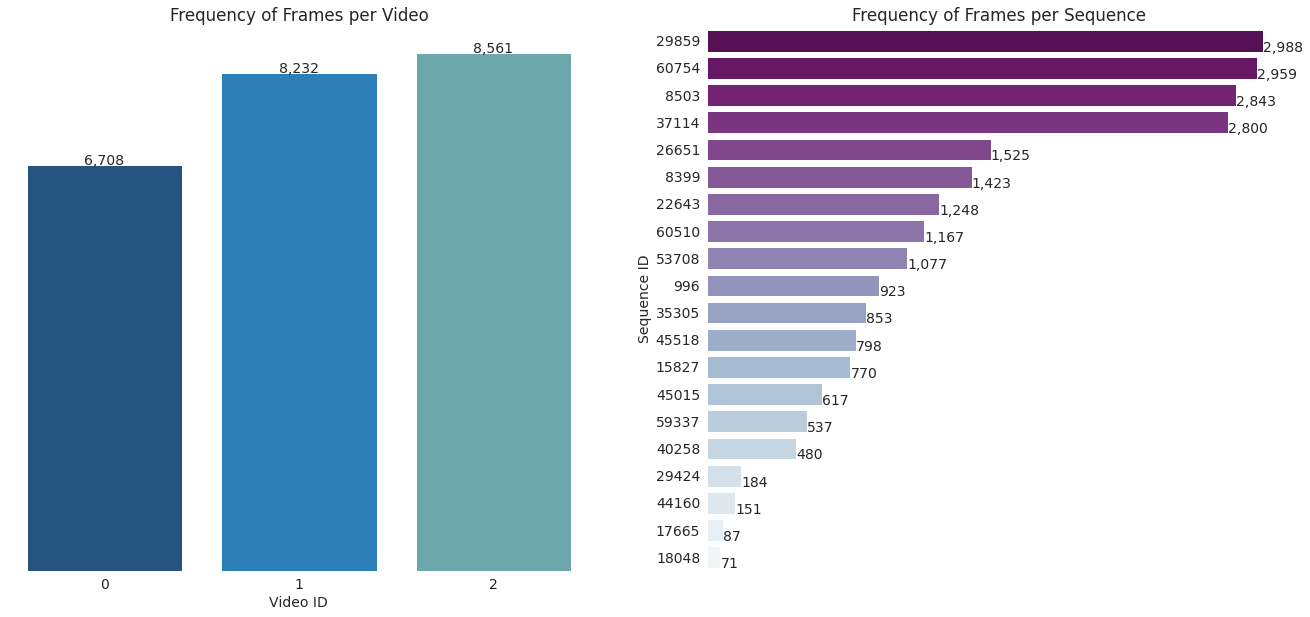

In [6]:
# 🐝 Log plots into W&B Dashboard
create_wandb_plot(x_data=df1.index, 
                  y_data=df1.video_id, 
                  x_name="Video ID", y_name=" ", 
                  title="-Frequency of Frames per Video-", 
                  log="frames", plot="bar")

create_wandb_plot(x_data=df2.index, 
                  y_data=df2.sequence, 
                  x_name="Sequence ID", y_name=" ", 
                  title="-Frequency of Frames per Sequence-", 
                  log="frames2", plot="bar")

In [7]:
# Calculate the number of total annotations within the frame
train_df["no_annotations"] = train_df["annotations"].apply(lambda x: len(eval(x)))

In [8]:
# % annotations
n = len(train_df)
no_annot = round(train_df[train_df["no_annotations"]==0].shape[0]/n*100)
with_annot = round(train_df[train_df["no_annotations"]!=0].shape[0]/n*100)

print(color.S + f"There are ~{no_annot}% frames with no annotation and" + color.E,
      "\n",
      color.S + f"only ~{with_annot}% frames with at least 1 annotation." + color.E)

# Plot
plt.figure(figsize=(23, 6))
sns.histplot(train_df["no_annotations"], bins=19, kde=True, element="step", 
             color=my_colors[5])

plt.xlabel("Number of Annotations")
plt.ylabel("Frequency")
plt.title("Distribution for Number of Annotations per Frame")

sns.despine(top=True, right=True, left=False, bottom=True)

n = len(train_df)
no_annot = round(train_df[train_df.no_annotations==0].shape[0]/n*100)
with_annot = round(train_df[train_df.no_annotations!=0].shape[0]/n*100)

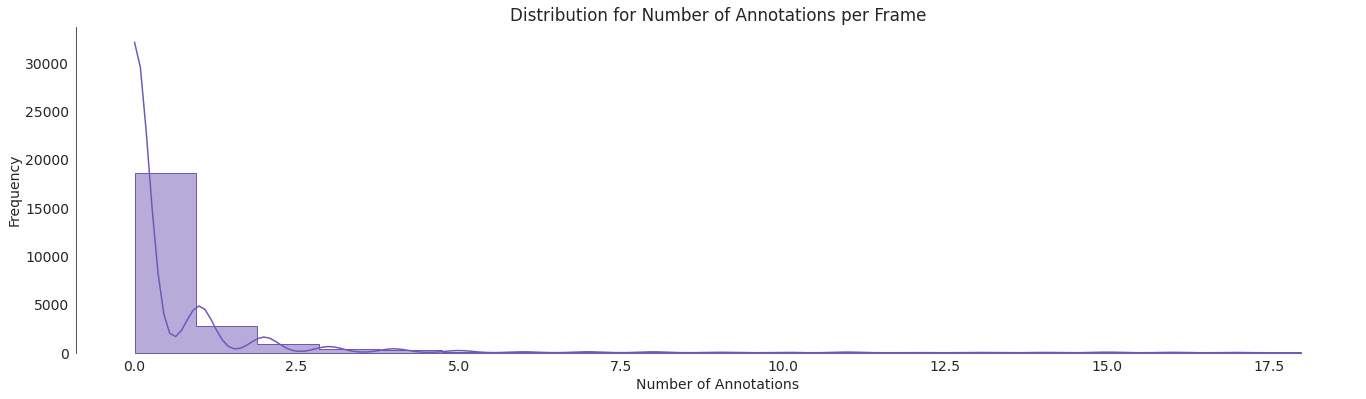

In [9]:
# 🐝 Log info and plots into W&B Dashboard
wandb.log({"no annotations": no_annot,
           "with annotations": with_annot})

create_wandb_hist(x_data=train_df["no_annotations"],
                  x_name="Number of Annotations",
                  title="Distribution for Number of Annotations per Frame",
                  log="annotations")

In [10]:
# List of unique sequence values
sequences = list(train_df["sequence"].unique())

plt.figure(figsize=(23,20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
plt.suptitle("Frequency of annotations on sequence length", fontsize = 20)

# Enumerate through all sequences
for k, sequence in enumerate(sequences):
    train_df[train_df["sequence"] == sequence]
    df_seq = train_df[train_df["sequence"] == sequence]
    
    plt.subplot(5, 4, k+1)
    plt.title(f"Sequence: {sequence}", fontsize = 12)
    plt.xlabel("Seq Frame", fontsize=10)
    plt.ylabel("No. Annot", fontsize=10)
    plt.xticks(fontsize=10); plt.yticks(fontsize=10)
    sns.lineplot(x=df_seq["sequence_frame"], y=df_seq["no_annotations"],
                 color=my_colors[2], lw=3)

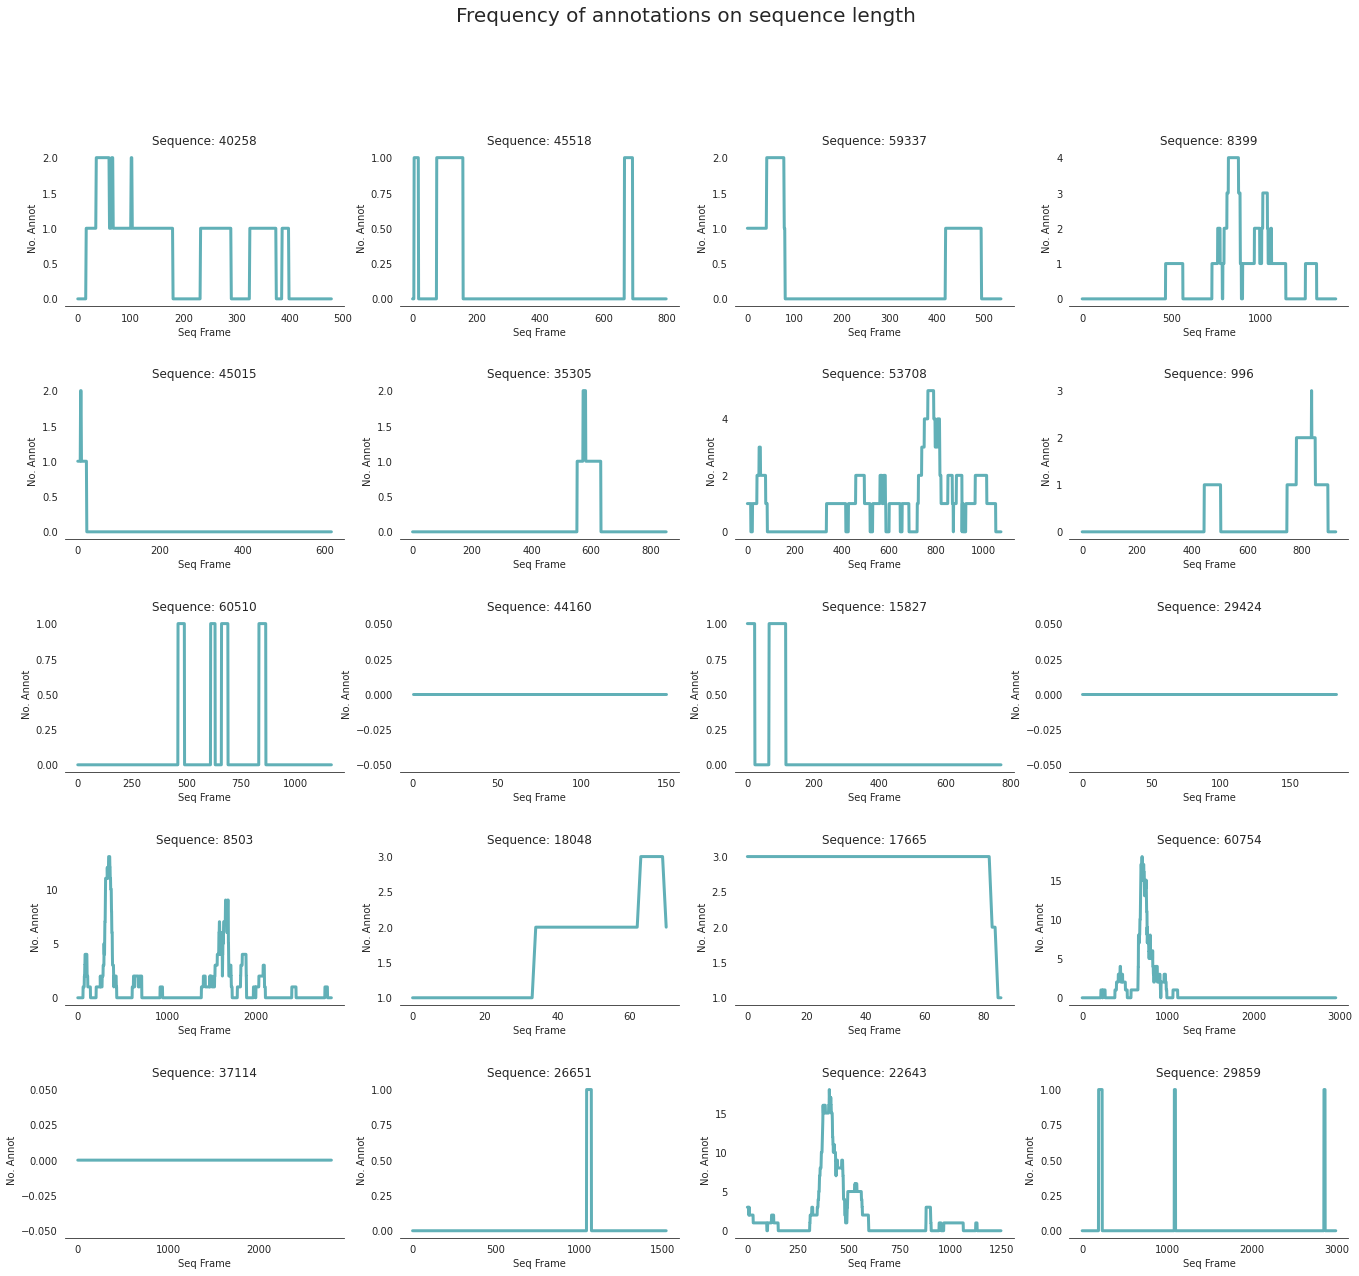

In [11]:
wandb.finish()